# ReactomeGSA - Atopic Dermatitis Example (analysing GEO datasets)

This notebook showcases how to use the `ReactomeGSA` package to compare three studies studying the effect of biologics / small molecules as treatment for atopic dermatitis.

All of these three datasets are available on GEO. Most of the notebook centers around how to retrieve these datasets and format them to be used with `ReactomeGSA`.

## Setup

The `ReactomeGSA` R package is available through Bioconductor.

The following code installs `BiocManager` (if not yet available), which is Bioconductor's tool to install the respective packages.

In [1]:
# Check if BiocManager is installed, if not, install it
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Check if the ReactomeGSA package is available, if not, install it using BiocManager
if (!require("ReactomeGSA"))
    BiocManager::install("ReactomeGSA")

Loading required package: ReactomeGSA



In [2]:
# additionally, load the tidyverse packages
suppressPackageStartupMessages({
    library(tidyr)
    library(readr)
    library(dplyr)
    library(ggplot2)
    
    # we will use GEOquery to download metadata and sample data from GEO
    library(GEOquery)
})

# ReactomeGSA Usage

`ReactomeGSA` supports several 'omics data types as input. The complete list of suported data types can be retrieved using the `get_reactome_data_types()` function.

In [3]:
# disply all supported 'omics data types
get_reactome_data_types()

rnaseq_counts:
   RNA-seq (raw counts) 
   Raw RNA-seq based read counts per gene (recommended). 
rnaseq_norm:
   RNA-seq (normalized) 
   log2 transformed, normalized RNA-seq based read counts per gene (f.e. RPKM, TPM) 
proteomics_int:
   Proteomics (intensity) 
   Intensity-based quantitative proteomics data (for example, iTRAQ/TMT or intensity-based label-free quantitation). Values must be log2 transformed. 
proteomics_sc:
   Proteomics (spectral counts) 
   Raw spectral-counts of label-free proteomics experiments 
microarray_norm:
   Microarray (normalized) 
   Normalized and log2 transformed microarray-based gene expression values. 


Additionally, `ReactomeGSA` supports several pathway analysis methods. Generally, we recommend to use `PADOG` for classical two-group comparisons as it is most likely to rank relevant pathways at the top (ie. with lower p-values).

Camera also performs two-group comparisons but is significantly faster than PADOG - which is the reason we use it in this vignette.

In [4]:
# List all available pathway analysis methods
get_reactome_methods()

PADOG: Weighted gene set analysis method that down-weighs genes that are present in many pathways.
Camera: A gene set analysis algorithm similar to the classical GSEA algorithm as implemented in the limma package
ssGSEA: The ssGSEA approach to derive pathway expression values for every sample. Note: The Reactome visualization is only available for up to 15 samples.


In [5]:
# in order to get some detailed informations about a specific function, set the
# `print_details` argument to TRUE
get_reactome_methods(method = "PADOG", print_details = TRUE)

+--------+
| PADOG: |
+--------+

Weighted gene set analysis method that down-weighs genes that are present in many pathways. 

Parameters:
- use_interactors
  Type: bool
  Default: False
  Scope: analysis
  Description: Indicates whether interactors from IntAct should be used to extent REACTOME's pathways in the analysis.
- include_disease_pathways
  Type: bool
  Default: True
  Scope: analysis
  Description: Disease pathways in Reactome may lead to a skewed analysis result. Note: Excluding disease pathways currently prevents the visualization of results in the Reactome pathway browser.
- max_missing_values
  Type: float
  Default: 0.5
  Scope: dataset
  Description: The maximum (relative) number of missing values within one comparison group before a gene / protein is removed from analysis. If no comparison groups are defined (for example for 'ssGSEA', the number of missing values accross all samples is used. Must be between 0-1.
- create_reactome_visualization
  Type: bool
  Default:

## Example - Treatment response in atopic dermatitis

In this example, we will compare the treatment effect of three tested compounds in atopic dermatitis.

This example uses data from three different studies:

  * GSE137430 (transcriptomics): Ungar *et al.*, Atopic dermatitis, **secukinumab** vs. control at week 16
  * GSE140684 (microarray): Khattri *et al.*, Atopic dermatitis, **ustekinumab**, weeks 0, 4, 16, crossover at week 16, 20, and 32
  * GSE133385 (microarray): Pavel *et al.*, **JAK/SYK Inhibitor ASN002** (20 mg, 40 mg, 80 mg, placebo), baseline, d15, d29

In [6]:
# first we need to create a ReactomeAnalysisRequest
# Here, we use Camera to speed up the example
requ <- ReactomeAnalysisRequest(method = "Camera")

### Secukinumab

The data from this study is available at GEO as **GSE137430**.

The expression data is available as a compressed CSV file while the metadata is stored in GEO's format which is accessible through the `GEOquery` package.

In [7]:
# Using readr's read_csv function we can directly "open" (ie. download) a file from GEO
suppressMessages({
    secu_expr <- read_csv("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE137430&format=file&file=GSE137430_exp.csv.gz")
})

In [8]:
# The first column contains the Gene
colnames(secu_expr)[1] <- "Gene"

In [9]:
# remove all messed up gene names - someone used MS Excel :-)
secu_expr <- filter(.data = secu_expr, !Gene %in% c("1-Mar", "2-Mar"))

In [10]:
# the expression data is now stored in a classical matrix with the samples as columns
# and genes as rows
secu_expr[1:5, 1:5]

Gene,1_S1_L002_R1_001,10_S10_L003_R1_001,100_S32_L004_R1_001,101_S33_L004_R1_001
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
WASH7P,2.7070184,2.8088395,2.866055,2.8978108
MIR6859-1,0.5281158,-0.5754674,0.178407,0.7124557
LOC101927589,-5.9476176,-4.4167697,-4.167368,-4.2417406
LOC729737,3.2198006,3.7548241,2.694753,3.2739592
LOC102723897,2.8821052,2.9553699,1.927150,3.8995151


Note that even though this is a transcriptomics study, the values are not discrete numbers. Therefore, we know that some kind of normalisation was already performed by the authors.

In [11]:
# increase the connection buffer for getGEO
Sys.setenv("VROOM_CONNECTION_SIZE" = 512000)

# we can now download the study's metadata using the getGEO function
secu_geo <- getGEO('GSE137430')

Found 1 file(s)

GSE137430_series_matrix.txt.gz

Rows: 0 Columns: 166

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (166): ID_REF, GSM4079133, GSM4079134, GSM4079135, GSM4079136, GSM407913...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

File stored at: 

/tmp/RtmpPh9FD8/GPL20301.soft



In [12]:
# The resulting query object is a list of entries, we can always use the first since
# we only searched for one study
# The data is returned as an ExpressionSet object, therefore, the metadata is
# available through the pData function
secu_meta <- pData(secu_geo[[1]])

In [13]:
# let's have a look at the data
secu_meta[1:5,1:5]

,title,geo_accession,status,submission_date,last_update_date
,<chr>,<chr>,<chr>,<chr>,<chr>
GSM4079133,1_S1_L002_R1_001_BL_NL,GSM4079133,Public on Sep 01 2020,Sep 13 2019,Sep 01 2020
GSM4079134,10_S10_L003_R1_001_W16_LS,GSM4079134,Public on Sep 01 2020,Sep 13 2019,Sep 01 2020
GSM4079135,100_S32_L004_R1_001_W16_LS,GSM4079135,Public on Sep 01 2020,Sep 13 2019,Sep 01 2020
GSM4079136,101_S33_L004_R1_001_BL_NL,GSM4079136,Public on Sep 01 2020,Sep 13 2019,Sep 01 2020
GSM4079137,102_S37_L005_R1_001_BL_LS,GSM4079137,Public on Sep 01 2020,Sep 13 2019,Sep 01 2020


Unfortunately, the sample IDs used in the metadata are different to the sample ids used in the expression data file. Therefore, we need additional code to match them.

Here, the `title` column in the metadata contains the sample ids that were used in the expression file.

In [14]:
# add the sample names found in the expression table to the metadata
secu_meta$sample_id <- NA

for (sample_id in colnames(secu_expr %>% dplyr::select(!"Gene"))) {
    # find a match using grep
    match_index <- grep(sample_id, secu_meta$title)
    
    if (length(match_index) > 0) {
        secu_meta$sample_id[match_index] <- sample_id
    } else {
        message("No match for ", sample_id)
    }
}

# adapt the rownames
rownames(secu_meta) <- secu_meta$sample_id

# match sort order to expression values
secu_meta <- secu_meta[colnames(secu_expr %>% dplyr::select(!"Gene")), ]

We can now check, how many samples are available at the relevant timepoints. The study had both a treatment (= Secukinumab) and a placebo group and analysed samples at different timepoints:

In [15]:
secu_meta %>%
    group_by(`treatment:ch1`, `timepoint:ch1`) %>%
    summarise(n = n())

`summarise()` has grouped output by 'treatment:ch1'. You can override using the `.groups` argument.



treatment:ch1,timepoint:ch1,n
<chr>,<chr>,<int>
Placebo,BL,26
Placebo,W16,17
Placebo,W4,13
Secukinumab,BL,53
Secukinumab,W16,34
Secukinumab,W4,22


In [16]:
# We now merge the expression values and the metadata into a single
# ExpressionSet object. This greatly simplifies the filtering of
# metadata and samples.
pdata <- new("AnnotatedDataFrame", data=secu_meta)

secu_eset <- ExpressionSet(
    assayData = as.matrix(tibble::column_to_rownames(secu_expr, var = "Gene")), 
    phenoData = pdata)

secu_eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 23578 features, 165 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: 1_S1_L002_R1_001 10_S10_L003_R1_001 ...
    99_S31_L004_R1_001 (165 total)
  varLabels: title geo_accession ... sample_id (48 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

We now want to compare the placebo *vs.* the treated samples at week 16 of the study. Therefore, we limit the dataset to samples obtained at week 16 and then set the `treatment:ch1` column (which contains our treatment information) as our `comparison_factor`. We can then compare the Placebo and Secukinumab group by setting `comparison_group_1` and `comparison_group_2` accordingly.

In [17]:
requ <- add_dataset(requ, 
                    expression_values = secu_eset[, secu_eset$`timepoint:ch1` == "W16"], 
                    name = "Secukinumab", 
                    type = "rnaseq_norm", 
                    comparison_factor = "treatment:ch1", 
                    comparison_group_1 = "Placebo", 
                    comparison_group_2 = "Secukinumab")

Converting expression data to string... (This may take a moment)

Conversion complete



Our `ReactomeAnalysisRequestObject` now contains the first dataset:

In [18]:
requ

ReactomeAnalysisRequestObject
  Method = Camera
  Parameters: none
  Datasets:
  - Secukinumab (rnaseq_norm)
    No parameters set.

### Ustekinumab

This microarray study has both its expression values, as well as its metadata available in GEO's standard format. Therefore, we can retrieve both in a single object using the `getGEO` function:

In [19]:
uste_gset <- getGEO("GSE140684", GSEMatrix=TRUE, getGPL=FALSE)

Found 1 file(s)

GSE140684_series_matrix.txt.gz

Rows: 54675 Columns: 153

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): ID_REF
dbl (152): GSM4180248, GSM4180249, GSM4180250, GSM4180251, GSM4180252, GSM41...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [20]:
# change from the list to the eset object
uste_gset <- uste_gset[[1]]

In [21]:
# view the expression values
exprs(uste_gset)[1:5,1:5]

,GSM4180248,GSM4180249,GSM4180250,GSM4180251,GSM4180252
1007_s_at,11.003970,10.749789,11.053181,11.097672,10.855124
1053_at,8.921461,8.984883,8.966604,8.592084,8.665176
117_at,5.990361,7.038691,6.887491,6.114766,5.851292
121_at,5.651296,5.398563,5.453685,5.608690,4.608677
1255_g_at,2.172021,2.172021,2.172021,2.172021,2.172021


In [22]:
# view the metadata
pData(uste_gset)[1:5, 1:5]

,title,geo_accession,status,submission_date,last_update_date
,<chr>,<chr>,<chr>,<chr>,<chr>
GSM4180248,Subject2.W0.NL.Stelara,GSM4180248,Public on Nov 20 2019,Nov 19 2019,Nov 20 2019
GSM4180249,Subject2.W0.LS.Stelara,GSM4180249,Public on Nov 20 2019,Nov 19 2019,Nov 20 2019
GSM4180250,Subject2.W4.LS.Stelara,GSM4180250,Public on Nov 20 2019,Nov 19 2019,Nov 20 2019
GSM4180251,Subject3.W0.NL.Placebo,GSM4180251,Public on Nov 20 2019,Nov 19 2019,Nov 20 2019
GSM4180252,Subject3.W0.LS.Placebo,GSM4180252,Public on Nov 20 2019,Nov 19 2019,Nov 20 2019


Again, we can summarise the number of samples per treatment group and timepoint to select our relevant comparison factors

In [23]:
pData(uste_gset) %>%
    group_by(`treatment:ch1`, `timepoint:ch1`) %>%
    summarise(n = n())

`summarise()` has grouped output by 'treatment:ch1'. You can override using the `.groups` argument.



treatment:ch1,timepoint:ch1,n
<chr>,<chr>,<int>
Placebo,W0,24
Placebo,W16,23
Placebo,W20,4
Placebo,W32,9
Placebo,W4,16
Ustekinumab,W0,28
Ustekinumab,W16,20
Ustekinumab,W20,4
Ustekinumab,W32,8


For this dataset, we now select the `W16` timepoint as it has the highest number of samples and again compare the Placebo against the treatment (= Ustekinumab) group:

In [24]:
# we add a second dataset by simoly calling the add_dataset function again with the new object and information
requ <- add_dataset(requ, 
                    expression_values = uste_gset[, uste_gset$`timepoint:ch1` == "W16"], 
                    name = "Ustekinumab", 
                    type = "microarray_norm", 
                    comparison_factor = "treatment:ch1", 
                    comparison_group_1 = "Placebo", 
                    comparison_group_2 = "Ustekinumab")

Converting expression data to string... (This may take a moment)

Conversion complete



### JAK Inhib.

Similar to the previous study, the complete data is available through the getGEO function:

In [25]:
jak_gset <- getGEO("GSE133385", GSEMatrix =TRUE, getGPL=FALSE)[[1]]

Found 1 file(s)

GSE133385_series_matrix.txt.gz

Rows: 28976 Columns: 112

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): ID_REF
dbl (111): GSM3907370, GSM3907372, GSM3907374, GSM3907375, GSM3907376, GSM39...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [26]:
pData(jak_gset) %>%
    group_by(`treatment:ch1`, `week:ch1`) %>%
    summarise(n = n())

`summarise()` has grouped output by 'treatment:ch1'. You can override using the `.groups` argument.



treatment:ch1,week:ch1,n
<chr>,<chr>,<int>
20mg,Day1,14
20mg,Day15,4
20mg,Day29,7
40mg,Day1,16
40mg,Day15,7
40mg,Day29,6
80mg,Day1,16
80mg,Day15,6
80mg,Day29,8


For this study, we'll again compare the last timepoint and the highest dose (= 80 mg) with the placebo group.

In [27]:
# add to the request
requ <- add_dataset(requ, 
                    expression_values = jak_gset[, jak_gset$`week:ch1` == "Day29"], 
                    name = "JAK", 
                    type = "microarray_norm", 
                    comparison_factor = "treatment:ch1", 
                    comparison_group_1 = "Placebo", 
                    comparison_group_2 = "80mg")

Converting expression data to string... (This may take a moment)

Conversion complete



### Run the analysis

Our `ReactomeAnalysisRequestObject` now contains all three datasets:

In [28]:
requ

ReactomeAnalysisRequestObject
  Method = Camera
  Parameters: none
  Datasets:
  - Secukinumab (rnaseq_norm)
    No parameters set.
  - Ustekinumab (microarray_norm)
    No parameters set.
  - JAK (microarray_norm)
    No parameters set.

The complete analysis is performed through the `perform_reactome_analysis` function:

In [29]:
camera_res <- perform_reactome_analysis(requ)

Submitting request to Reactome API...

Compressing request data...

Reactome Analysis submitted succesfully

Queued

Converting dataset Secukinumab...

Converting dataset Ustekinumab...

Converting dataset JAK...

Mapping identifiers...

Performing gene set analysis using Camera

Analysing dataset 'Secukinumab' using Camera

Analysing dataset 'Ustekinumab' using Camera

Analysing dataset 'JAK' using Camera

Creating REACTOME visualization

Retrieving result...



### Investigate results

The result is stored as a `ReactomeAnalysisResult` object. Here we can see that we have pathway analysis results for all three datasets, the used Reactome version and a Reactome visualization of our results:

In [30]:
camera_res

ReactomeAnalysisResult object
  Reactome Release: 78
  Results:
  - Secukinumab:
    2486 pathways
    13546 fold changes for genes
  - Ustekinumab:
    2489 pathways
    20095 fold changes for genes
  - JAK:
    2405 pathways
    13957 fold changes for genes
  Reactome visualizations:
  - Gene Set Analysis Summary

In [31]:
# using the open_reactome function we can look at the web-based visualization of the results
# NOTE: The link is only working for around 2-4 weeks (depending on the overal usage)
open_reactome(camera_res)

Opening https://www.reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS=MjAyMjAzMTMxNjIxMzlfMjE4MDY%3D in the default browser...



url 
"https://www.reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS=MjAyMjAzMTMxNjIxMzlfMjE4MDY%3D"

We can retrieve all pathways using the `pathways` method. This already combines the results from all three datasets.

In [32]:
my_pathways <- pathways(camera_res)

my_pathways[1:5,1:5]

,Name,Direction.Secukinumab,FDR.Secukinumab,PValue.Secukinumab,NGenes.Secukinumab
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
R-HSA-6805567,Keratinization,Up,4.945071e-09,1.989168e-12,174
R-HSA-6809371,Formation of the cornified envelope,Up,5.907370e-03,4.752510e-06,113
R-HSA-173623,Classical antibody-mediated complement activation,Down,2.816931e-02,3.748920e-05,7
R-HSA-977606,Regulation of Complement cascade,Down,2.816931e-02,4.532472e-05,40
R-HSA-166658,Complement cascade,Down,3.271989e-02,6.580830e-05,49


We can use the `plot_heatmap` function to get the data in a nice format for `ggplot2`:

In [33]:
plot_data <- plot_heatmap(camera_res, return_data = TRUE)
plot_data[1:4,]

Name,n_sig,dataset,direction
<chr>,<dbl>,<chr>,<fct>
Keratinization,1,Secukinumab,sig Up
Keratinization,1,Ustekinumab,non-sig Up
Keratinization,1,JAK,non-sig Up
Formation of the cornified envelope,1,Secukinumab,sig Up


We can now use `dplyr` to only select the pathways of interest.

In [34]:
plot_data <- plot_data %>%
    # only pathways significantly changed in at least one dataset
    filter(n_sig > 0) %>%
    # additionally, limit to a selection of pathways of interest based on their name 
    # (this was only added after investigating the whole result)
    filter(grepl("MHC", Name) | grepl("Interferon", Name) | grepl("Interleukin", Name) | grepl("KIT", Name) | grepl("TCR", Name) | grepl("Immune", Name) | grepl("Kreatin", Name) | grepl("Cytokine", Name) | grepl("Complement", Name) | grepl("Antigen", Name) | grepl("Chemokin", Name))

Comparing 1 vs 2

Comparing 1 vs 3

Comparing 2 vs 3

Warning message:
“Removed 15 rows containing missing values (geom_point).”


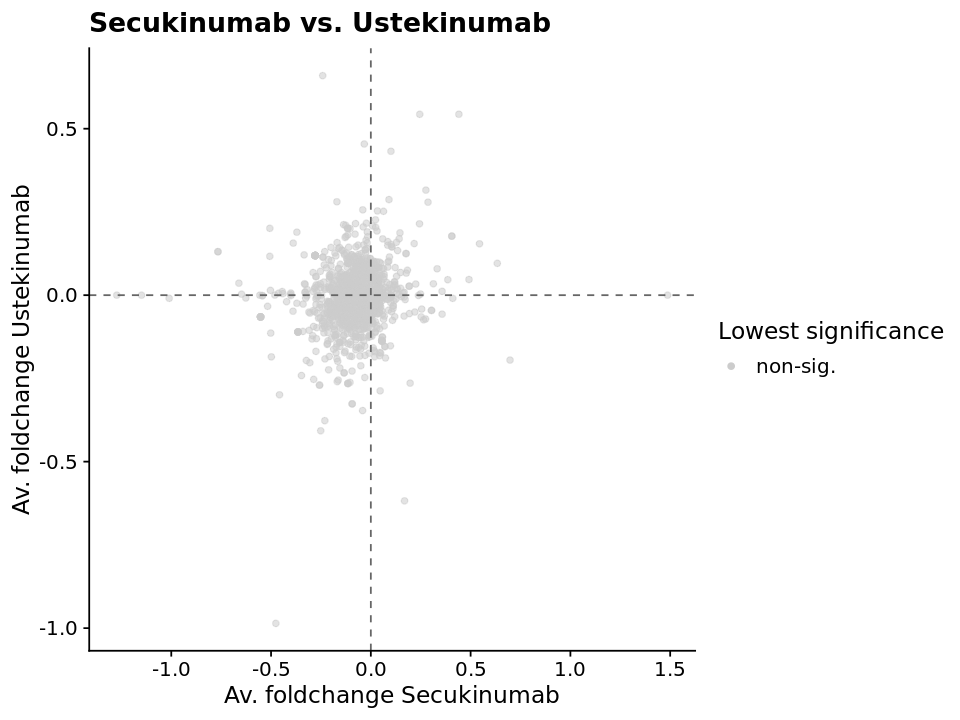

In [35]:
corr_plots <- plot_correlations(camera_res)

options(repr.plot.width = 8, repr.plot.height = 6)

p <- corr_plots[[1]] + cowplot::theme_cowplot()

#svg("corr_plot.svg", width = 8, height = 6)
#print(p)
#dev.off()

p

png 
  2

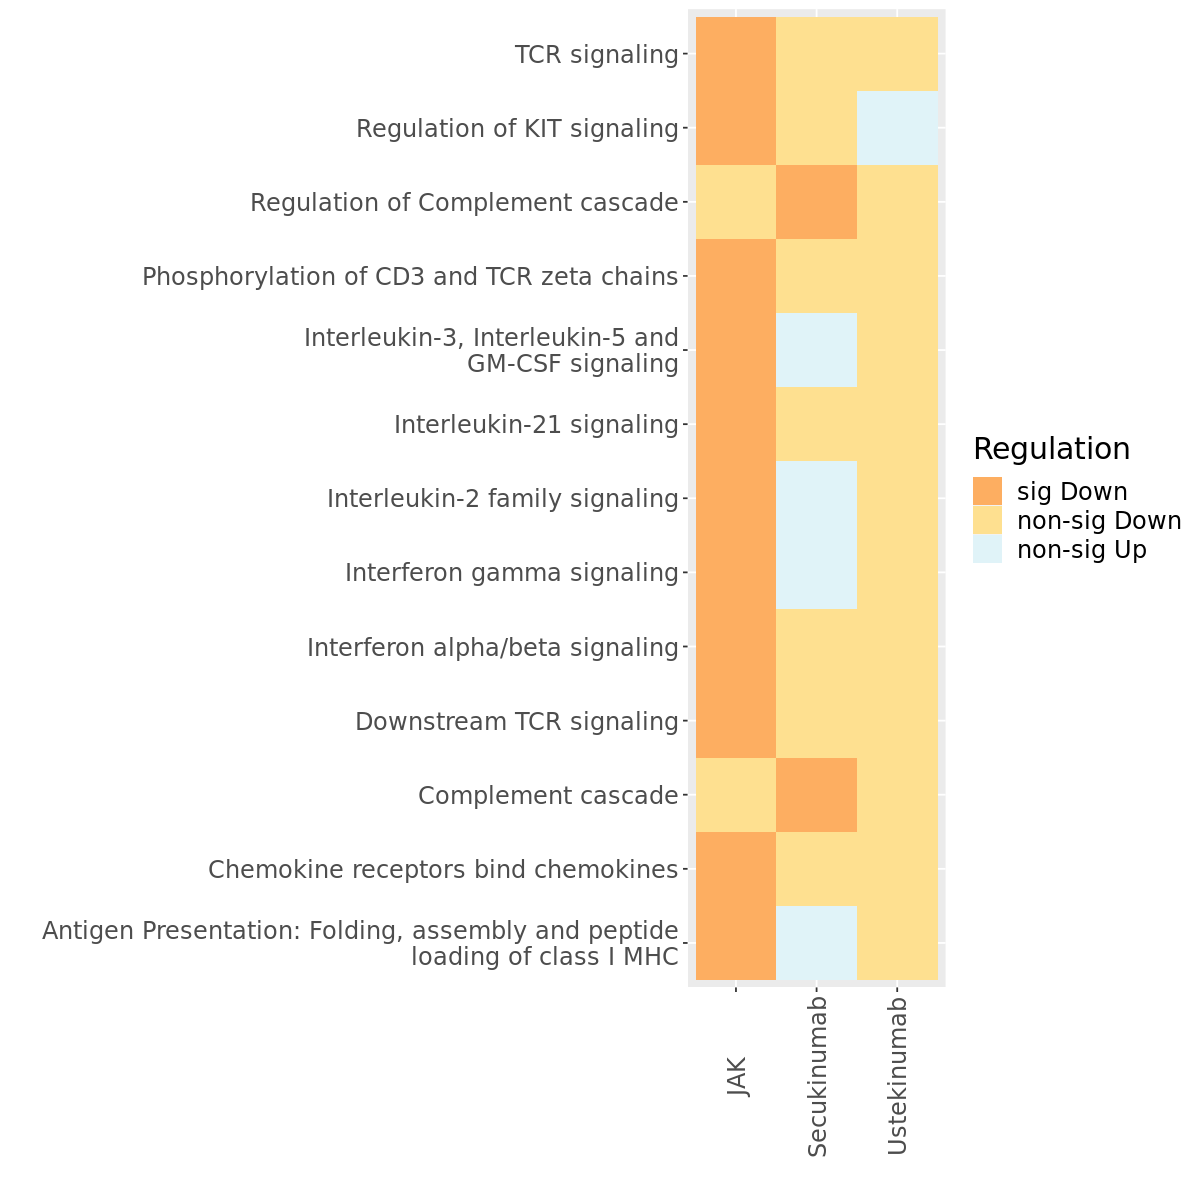

In [36]:
options(repr.plot.width = 10, repr.plot.height = 10)
# Use ggplot's geom_tile function to create a nice heatmap
p <- ggplot(plot_data, aes(x = dataset, y = Name, fill = direction)) +
    geom_tile() +
    scale_fill_manual(values = c("#FDAE61", "#FEE090", "#E0F3F8", "#4575B4")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=0.5)) +
    theme(text = element_text(size = 18)) +
    labs(x = "", y = "", fill = "Regulation")

svg("heatmap.svg", width = 10, height = 10)
print(p)
dev.off()

p

We can immediately see, that only treatment with JAK-inhibitors led to a significant down-regulation of several immune-related pathways.

# Time Series Analysis

Timeseries data can be analysed in `ReactomeGSA` by adding the same dataset multiple times with different comparisons.

Here, we will test how the difference between treatment and Placebo group changed over time for the JAK inhibitor study.

In [37]:
# The JAK datasets contains several timepoints
pData(jak_gset) %>%
    group_by(`treatment:ch1`, `week:ch1`) %>%
    summarise(n = n())

`summarise()` has grouped output by 'treatment:ch1'. You can override using the `.groups` argument.



treatment:ch1,week:ch1,n
<chr>,<chr>,<int>
20mg,Day1,14
20mg,Day15,4
20mg,Day29,7
40mg,Day1,16
40mg,Day15,7
40mg,Day29,6
80mg,Day1,16
80mg,Day15,6
80mg,Day29,8


In [38]:
# Create a new ReactomeAnalysisRequest object
jak_request <- ReactomeAnalysisRequest(method = "Camera")

# First, only use samples from day 1
jak_request <- add_dataset(jak_request, 
                    expression_values = jak_gset[, jak_gset$`week:ch1` == "Day1"], 
                    name = "Day1", 
                    type = "microarray_norm", 
                    comparison_factor = "treatment:ch1", 
                    comparison_group_1 = "Placebo", 
                    comparison_group_2 = "80mg")

# Next, we add day 15
jak_request <- add_dataset(jak_request, 
                    expression_values = jak_gset[, jak_gset$`week:ch1` == "Day15"], 
                    name = "Day15", 
                    type = "microarray_norm", 
                    comparison_factor = "treatment:ch1", 
                    comparison_group_1 = "Placebo", 
                    comparison_group_2 = "80mg")

# Finally, day 29
jak_request <- add_dataset(jak_request, 
                    expression_values = jak_gset[, jak_gset$`week:ch1` == "Day29"], 
                    name = "Day29", 
                    type = "microarray_norm", 
                    comparison_factor = "treatment:ch1", 
                    comparison_group_1 = "Placebo", 
                    comparison_group_2 = "80mg")

# And simply start the analysis
jak_dose_result <- perform_reactome_analysis(jak_request)

Converting expression data to string... (This may take a moment)

Conversion complete

Converting expression data to string... (This may take a moment)

Conversion complete

Converting expression data to string... (This may take a moment)

Conversion complete

Submitting request to Reactome API...

Compressing request data...

Reactome Analysis submitted succesfully

Converting dataset Day1...

Converting dataset Day15...

Converting dataset Day29...

Mapping identifiers...

Performing gene set analysis using Camera

Analysing dataset 'Day1' using Camera

Analysing dataset 'Day15' using Camera

Analysing dataset 'Day29' using Camera

Creating REACTOME visualization

Retrieving result...



We can now again use our previous custom plotting function, to get an overview over regulated immune pathways:

In [39]:
plot_data <- plot_heatmap(jak_dose_result, return_data = TRUE) %>%
    # only pathways significantly changed in at least one dataset
    filter(n_sig > 0) %>%
    # additionally, limit to a selection of pathways of interest based on their name 
    # (this was only added after investigating the whole result)
    filter(grepl("MHC", Name) | grepl("Interferon", Name) | grepl("Interleukin", Name) | grepl("KIT", Name) | grepl("TCR", Name) | grepl("Immune", Name) | grepl("Kreatin", Name) | grepl("Cytokine", Name) | grepl("Complement", Name) | grepl("Antigen", Name) | grepl("Chemokin", Name))

png 
  2

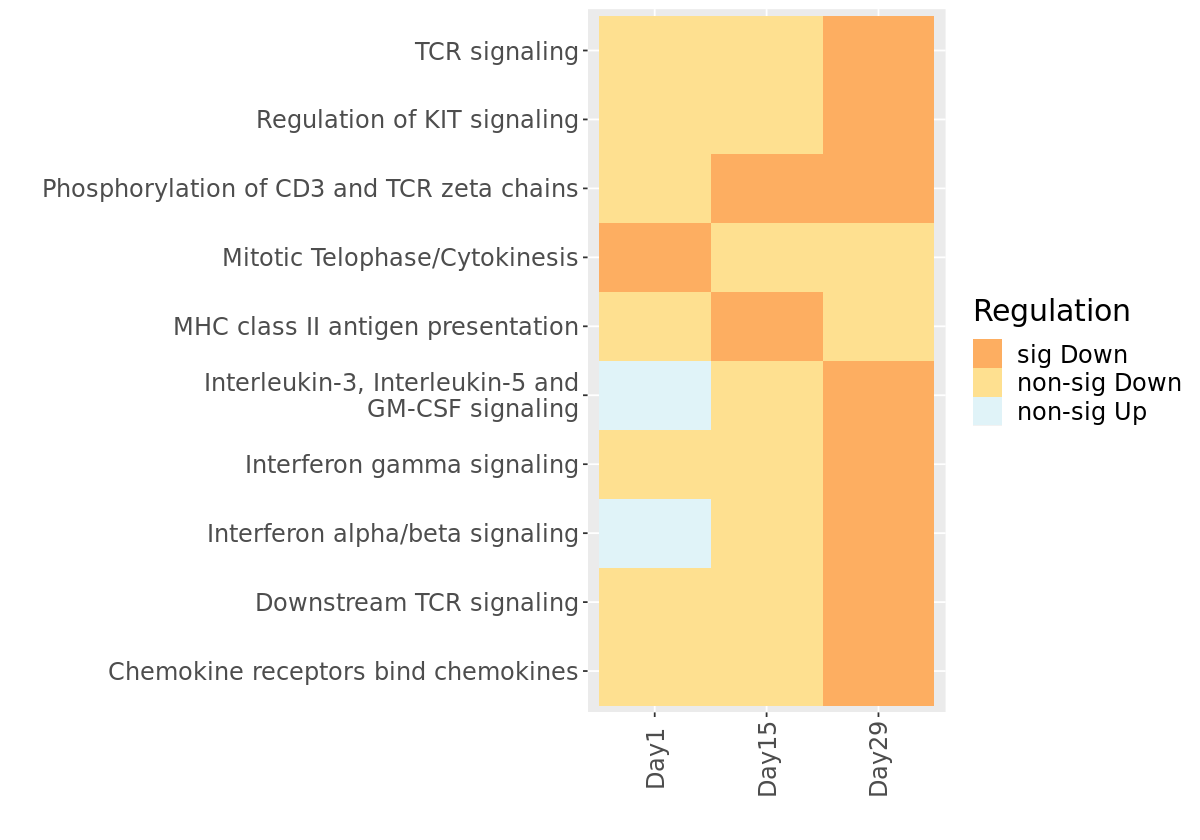

In [40]:
options(repr.plot.width = 10, repr.plot.height = 7)
# Use ggplot's geom_tile function to create a nice heatmap
p <- ggplot(plot_data, aes(x = dataset, y = Name, fill = direction)) +
    geom_tile() +
    scale_fill_manual(values = c("#FDAE61", "#FEE090", "#E0F3F8", "#4575B4")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=0.5)) +
    theme(text = element_text(size = 18)) +
    labs(x = "", y = "", fill = "Regulation")

svg("time_series.svg", width = 10, height = 7)
print(p)
dev.off()

p

As expected, most immune pathways are only down-regulated starting from day 15.

# SessionInfo

In [3]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] GEOquery_2.60.0     Biobase_2.52.0      BiocGenerics_0.38.0
[4] ggplot2_3.3.5       dplyr_1.0.7         readr_2.0.2        
[7] tidyr_1.1.4         ReactomeGSA_1.7.4  

loaded via a namespace (and not attached):
 [1] pillar_1.6.4        compiler_4.1.